# Imports



In [ ]:
pip install columnar #package to print table of data 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from collections import defaultdict
import sys
import math
import time
import heapq
import gc
import zipfile
import random
import numpy as np
from time import perf_counter_ns, perf_counter
import os
import matplotlib.pyplot as plt
from columnar import columnar
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/mincut_dataset.zip', 'r') as zip_ref:

     zip_ref.extractall('/content/')

# Classes and handy functions

In this section we define some useful classes and functions for our algorithm implementations.

In [ ]:
class Graph_Karger():
  def __init__ (self,size):
    self.V=[]
    self.W = np.zeros((size,size))

  #The method adds an edge to weighted adjacency matrix.
  def add_edge(self, source_node, destination_node, weight):
    # First case
    # We add the source and the destination node only if the are not already present
    if (source_node not in self.V):
      self.V.append(source_node)
    
    if (destination_node not in self.V):
      self.V.append(destination_node)
    
    # Now we can add the edge
    self.W[source_node][destination_node]=weight
    self.W[destination_node][source_node]=weight
    

  def set_w(self,w):
    self.W = w

  # The method copy creates a new instance of the class GraphKarger whose elements are the same of the current one.
  def copy(self):
    graph = Graph_Karger(len(self.V))
    graph.V = copy.deepcopy(self.V)
    graph.W = copy.deepcopy(self.W)
    return graph

In [ ]:
class Graph_StoerWagner():
  def __init__ (self):
    self.V=[]
    self.E= defaultdict(list)
    self.adjacency_list = defaultdict((dict))

  def add_edge(self, source_node, destination_node, weight):
    # First case
    # We add the source and the destination node only if the are not already present
    if (source_node not in self.V):
      self.V.append(source_node)
    
    if (destination_node not in self.V):
      self.V.append(destination_node)
    
    # Now we can add the edge
    #edge = (source_node.vertex, destination_node.vertex, weight)
    self.E[(source_node,destination_node)] = weight

    # Now we update the graph
    self.adjacency_list[source_node][destination_node]= weight
    if (source_node != destination_node):
      self.adjacency_list[destination_node][source_node]= weight

  # Given an edge, the methods check if it's already present in the Graph.
  # If it already exists an edge (v1,v2), it sums to it the new weight. 
  # Otherwise, it adds the new edge calling the method add_edge.
  def update_edge(self,v1,v2,weight):
    if v1 == v2:
      return
    if (self.get_edge(v1,v2)!=0):
      old_weight = self.get_edge(v1,v2)
      tot = old_weight+weight
      self.adjacency_list[v1][v2] = tot
      if (v1 != v2):
        self.adjacency_list[v2][v1] = tot
        if ((v1,v2) in self.E):
          self.E[(v1,v2)]=tot
        elif ((v2,v1) in self.E):
          self.E[(v2,v1)]=tot
    else:
      self.add_edge(v1,v2,weight)
    

  def get_edge(self, v1,v2):
    if((v1,v2) in self.E):
      return self.E.get((v1,v2))
    elif ((v2,v1) in self.E):
      return self.E.get((v2,v1))
    else:
      return 0
      
  def remove_edge(self,v1,v2):
    weight = 0
    if((v1,v2) in self.E):
      weight = self.E[(v1,v2)]
      del self.E[(v1,v2)]
    else:
      weight = self.E[(v2,v1)]
      del self.E[(v2,v1)]
    
    self.adjacency_list[v1].pop(v2)
    self.adjacency_list[v2].pop(v1)
    
    
  # The method copy creates a new instance of the class Graph_StoerWagner whose elements are the same of the current one.
  def copy(self):
    graph = Graph_StoerWagner()
    graph.V = copy.deepcopy(self.V)
    graph.E = copy.deepcopy(self.E)
    graph.adjacency_list = copy.deepcopy(self.adjacency_list)
    return graph

In [ ]:
def read_input_graph(filepath,algorithm):
  f = open(filepath, "r")
  lines = f.readlines()
  for index, line in enumerate (lines):
    text = line.strip()
    text_splitted = text.split(" ")
    if (index==0):
      size = text_splitted[0]
      if algorithm=="Karger":
        graph = Graph_Karger(int(size))
      elif algorithm == "Stoer":
        graph = Graph_StoerWagner()
    else:
      if algorithm=="Karger":
        graph.add_edge(int(text_splitted[0])-1,int(text_splitted[1])-1,int(text_splitted[2]))
      elif algorithm=="Stoer":
        graph.add_edge(int(text_splitted[0]),int(text_splitted[1]),int(text_splitted[2]))

  f.close()
  return graph,int(size)

In [ ]:
def measure_run_time_karger(input_directory,weights):
  avg_sum_times = 0.0
  sizes = []
  total_times = []
  avg_run_times = []

  discovery_times=[]
  for file in sorted(os.listdir(input_directory)):
    print("------------------------------------------------------------------------")
    file_path = f"{input_directory}/{file}"
    original_graph,size = read_input_graph(file_path,"Karger")
    num_iterations=round(math.log2(size)**2)

    print(f"Reading file {file}")
    gc.disable()
    discovery_time = 0
    min_weight = 1e6
    start_time= perf_counter()
    for i in range(num_iterations):
      graph =  original_graph.copy()
      D,C= initialize_datastructures(graph)
      avg_start_time=perf_counter_ns()
      weight = (recursive_contract(D,graph.W,0))
      avg_end_time=perf_counter_ns()
      avg_sum_times += (avg_end_time-avg_start_time)
      if weight < min_weight:
        discovery_time= perf_counter()-start_time
        min_weight = weight
    end_time=perf_counter()

    weights.append(min_weight)
    sizes.append(size)
    gc.enable()

    time = end_time-start_time
    total_times.append(time)
    discovery_times.append(discovery_time)

    avg_time = (avg_sum_times/num_iterations)
    avg_run_times.append(avg_time)
    print(f"Weight minimum cut: {min_weight}, with discovery time {discovery_time} s, total time: {time} s, average time: {avg_time} ns")

  # return running time in nanoseconds
  return total_times,sizes,discovery_times,weights,avg_run_times
  



In [ ]:
def measure_run_time_stoer(input_directory):
  sum_times = 0.0
  num_iterations= 200
  sizes = []
  avg_run_times = []
  weights = []
  for file in sorted(os.listdir(input_directory)):
    print("------------------------------------------------------------------------")
    file_path = f"{input_directory}/{file}"
    graph,size = read_input_graph(file_path,"Stoer")
    print(f"Reading file {file}")
    gc.disable()
    for i in range(num_iterations):
      start_time=perf_counter_ns()
      cut,weight = global_min_cut(graph)
      end_time=perf_counter_ns()
      sum_times += (end_time-start_time)
    sizes.append(size)
    weights.append(weight)
    gc.enable()
    time = (sum_times/num_iterations)
    avg_run_times.append(time)
    print(f"Weight minimum cut: {weight}, total time: {time} ns")

  return avg_run_times,sizes,weights

In [ ]:
def read_input_data(filepath):
  f = open(filepath, "r")
  lines = f.readlines()
  alist = []
  for index, line in enumerate (lines):
    text = line.strip()
    text_splitted = text.split(",") 
    alist.append(int(float(text_splitted[0])))
  return alist

In [ ]:
def read_input_data_float(filepath):
  f = open(filepath, "r")
  lines = f.readlines()
  alist = []
  for index, line in enumerate (lines):
    text = line.strip()
    text_splitted = text.split(",") 
    alist.append(float(text_splitted[0]))
  return alist

#Karger and Stein's algorithm 
This section contains the methods to implement Karger and Stein's algorithm

In [ ]:
#This function is to initialize weighted degree of vertices and cumulative weight array.
def initialize_datastructures(graph):
  weighted_degree =np.zeros(len(graph.V))
  c = np.zeros(len(graph.V))
  for i in range(len(graph.V)):
    weighted_degree[i] = np.sum(graph.W[i])
    c[i] = c[i-1] +weighted_degree[i]
  return weighted_degree,c

In [ ]:
# This function returns the number of vertices with entries different from zero of the adjacency matrix
def get_num_vertices(W):
  count = np.count_nonzero(W>0,axis=0)
  tot = np.count_nonzero(count>0)
  return tot

In [ ]:
# The method returns the vertices of adjacency matrix W.
# For each row it checks if there exists an element greater than zero.
# Using np.where, it takes the indices of all vertices >0
def get_vertices_np(W):
  count = np.count_nonzero(W>0,axis=0)
  tot = np.where(count != 0)[0]
  return tot

In [ ]:
def random_select(C):
  r = int(random.uniform(0,C[-1]))

  low = 0
  high = len(C)-1
  best_ind = low

  # Binary search
  while low <= high:
    mid = low + (high - low) // 2
    # Condition to verify
    if (C[mid-1] <= r and r<C[mid]) or (mid==0 and r<=C[mid]):
      break
    elif C[mid] <=r:
      low = mid +1
    elif C[mid] > r:
      high =mid
  best_ind=mid
  return best_ind

In [ ]:
# The method chooses a vertex u with probability proportional to D[u]
def edge_select(D,W):
  weights_D = []
  total_weights = 0
  for i in range(len(D)):
    total_weights += (D[i])
    weights_D.append(total_weights)
  u = random_select(weights_D)

  weights_W = []
  total_weights = 0
  
  # Once u is fixed, choose v with probability proportional to W[u,v]
  for i in range (len(D)):
    total_weights += W[u][i]
    weights_W.append(total_weights)
  v = random_select(weights_W)
  return u,v

In [ ]:
# Once we have selected the edge (u,v), we have to contract the graph according to that edge
# The idea is to update the weight of u,v
def contract_edge_karger(D,W,u,v):
  D[u] = D[u] + D[v] - 2*W[u][v]
  D[v] = 0
  W[u][v] = W[v][u] = 0 # We remove u,v from the graph
  for w in (get_vertices_np(W)):   # We have to update the weights of the other edges
    if w!=u and w!=v:
      W[u][w] = W[u][w]+W[v][w]
      W[w][u] = W[w][u]+W[w][v]
      W[v][w] = 0
      W[w][v] = 0   
  return D,W 


In [ ]:
# The method conctract returns a contraction of G to k-vertices
# The graph G is represetend by the matrix W and the vector D

def contract(D,W,k):
  num_vertices = get_num_vertices(W)
  for i in range(num_vertices-k):
    u,v = edge_select(D,W)
    D,W =contract_edge_karger(D,W,u,v)
  return D,W

In [ ]:
def recursive_contract(D,W):
  num_vertices = get_num_vertices(W)
  
  if (num_vertices<=6):
    temp_D, W = contract(D,W,2)
    # The method checks if there exists at least an element greater than zero
    # In this case, it returns the first index 
    if (len(W[W>0])!=0):
      return (W[W>0][0])
    
  
  t = math.ceil((num_vertices/math.sqrt(2))+1)
  w = []

  for i in range (1,2):
    temp_D, W = contract(D,W,t)
    w.append(recursive_contract(temp_D,W))
  min_weight = min(w)
  return min_weight



# Stoer and Wagner
This section contains the methods to implement Stoer and Wagner's algorithm

In [ ]:
def st_mincut(graph):
  heap = []
  key = defaultdict(list) # we use this to keep track of the keys in the heap
  vertices = graph.V.copy()
  for u in graph.V:
    key[u] = 0
    heap.append((key[u],u)) # add nodes to the heap
  s = None
  t = None
  while heap:
    k,u = heapq.heappop(heap) #extract max element
    key[u] = 1e6 # flag to mark that u is no longer in the heap
    s = t
    t = u
    for vertex,weight in graph.adjacency_list[u].items():
      if key[vertex] != 1e6: # if v is in the heap
        index = heap.index((key[vertex],vertex)) # look for the index of vertex in the heap
        w = graph.get_edge(vertex,u) # weight of the edge (vertex,u)
        key[vertex] = key[vertex] - w #we subtract w since we are taking the opposite of the key (-key)
        heap[index] = (key[vertex],vertex) # modify key inside the heap
    heapq.heapify(heap) #mantain the heap invariant
  vertices.remove(t)
  return (vertices,t),s,t,-k

In [ ]:
def contract_edge_stoer(original_graph,u,v):
  graph = original_graph.copy()
  for w,weight in original_graph.adjacency_list[v].items():
    graph.remove_edge(v,w)
    # We update the edge of the contracted graph
    graph.update_edge(u,w,weight)
  graph.V.remove(v)
  del graph.adjacency_list[v]
  return graph


In [ ]:
def global_min_cut(graph):
  if len(graph.V)==2:
    return (graph.V[0],graph.V[1]),graph.get_edge(graph.V[0],graph.V[1]) #returns cut (v1,v2),weight(v1,v2)
  else:
    C1,s,t,weight_C1 = st_mincut(graph)
    contracted_graph = contract_edge_stoer(graph,s,t)
    C2,weight_C2 = global_min_cut(contracted_graph)
    if weight_C1 <= weight_C2:
      return C1,weight_C1
    else:
      return C2,weight_C2

# Results

In [ ]:
input_directory = '/content/dataset'


## Karger and Stein
Execution of Karger and Stein's algorithm on the input graphs

In [ ]:
weights_Karger =[]

In [ ]:
total_times_karger,sizes_karger,discovery_times_karger,weights_karger, avg_times_karger= measure_run_time_karger(input_directory,weights_Karger)

------------------------------------------------------------------------
Reading file input_random_01_10.txt
Weight minimum cut: 3056.0, with discovery time 0.0025349269999423996 s, total time: 0.01157103599985021 s, average time: 918322.7272727273 ns
------------------------------------------------------------------------
Reading file input_random_02_10.txt
Weight minimum cut: 223.0, with discovery time 0.0008055979999426199 s, total time: 0.006854692999922918 s, average time: 1457878.9090909092 ns
------------------------------------------------------------------------
Reading file input_random_03_10.txt
Weight minimum cut: 2302.0, with discovery time 0.002585053000075277 s, total time: 0.006911262000130591 s, average time: 2001718.9090909092 ns
------------------------------------------------------------------------
Reading file input_random_04_10.txt
Weight minimum cut: 4974.0, with discovery time 0.00229468999987148 s, total time: 0.007436408999865307 s, average time: 2579759.0 ns

## Stoer and Wagner
Execution of Stoer and Wagner's algorithm on the input graphs

In [ ]:
avg_runtimes_stoer,sizes_stoer,weights_stoer = measure_run_time_stoer(input_directory)

------------------------------------------------------------------------
Reading file input_random_01_10.txt
Weight minimum cut: 3056, total time: 995267.345 ns
------------------------------------------------------------------------
Reading file input_random_02_10.txt
Weight minimum cut: 223, total time: 1829620.705 ns
------------------------------------------------------------------------
Reading file input_random_03_10.txt
Weight minimum cut: 2302, total time: 2754048.74 ns
------------------------------------------------------------------------
Reading file input_random_04_10.txt
Weight minimum cut: 4974, total time: 3549839.765 ns
------------------------------------------------------------------------
Reading file input_random_05_20.txt
Weight minimum cut: 1526, total time: 7025988.8 ns
------------------------------------------------------------------------
Reading file input_random_06_20.txt
Weight minimum cut: 1684, total time: 10409800.51 ns
---------------------------------

# Fast initialization

This is just to get results of previous experiments that we stored in a text file so to avoid having to run the code multiple times

In [ ]:
sizes = read_input_data('/content/sizes.txt')


In [ ]:

# STOER
edges = read_input_data('/content/num_edges.txt') #gets number of edges from input graph
sizes = read_input_data('/content/sizes.txt')
weights_stoer = read_input_data('/content/weights_stoerwagner.txt')
avg_runtimes_stoer = read_input_data_float('/content/avg_runtimes_stoerwagner.txt')


In [ ]:
# KARGER
sizes_karger = sizes
weights_karger = read_input_data('/content/weights-karger.txt')
discovery_times_karger = read_input_data_float('/content/discovery-times-karger.txt')
avg_times_karger = read_input_data_float('/content/avg_times-karger.txt')
total_times_karger = read_input_data_float('/content/total_times_karger.txt')

In [ ]:
files = []
for file in sorted(os.listdir('/content/dataset')):
  files.append(file)
print(files)

In [ ]:
tuples_stoer = []
for size,weight,runtime in zip(sizes,weights_stoer, avg_runtimes_stoer):
  tuples_stoer.append((size,weight,runtime))


In [ ]:
tuples_karger = []
for size,weight,disc_time,total_time,avg_time in zip(sizes_karger,weights_karger,discovery_times_karger, total_times_karger,avg_times_karger):
  tuples_karger.append((size,weight,disc_time,total_time,avg_time))


# Plots
In this section we plot our results.

## Karger and Stein

In [ ]:
sorted_sizes_karger = list(zip(*tuples_karger))[0]
sorted_weights_karger = list(zip(*tuples_karger))[1]
sorted_runtimes_karger = list(zip(*tuples_karger))[4]

In [ ]:
sorted_weights_karger

Summary table of Karger's computation times

In [ ]:
headers = ["Filename","Size","Solution","Discovery Time (s)", "Total Time (s)","Average Time (ns)"]
data=[]
for i in range(len(sizes_karger)):
  data.append([files[i],tuples_karger[i][0], round(tuples_karger[i][1]),round(tuples_karger[i][2],7),round(tuples_karger[i][3],7),round(tuples_karger[i][4],5)])

table = columnar(data,headers, no_borders= False)
print(table)

|---------------|-----|--------|---------------|--------------|---------------|
|Filename       |Size |Solution|Discovery Time |Total Time (s)|Average Time (n|
|               |     |        |(s)            |              |s)             |
|=============================================================================|
|input_random_01|10   |3056    |0.0025349      |0.011571      |918322.72727   |
|_10.txt        |     |        |               |              |               |
|---------------|-----|--------|---------------|--------------|---------------|
|input_random_02|10   |223     |0.0008056      |0.0068547     |1457878.90909  |
|_10.txt        |     |        |               |              |               |
|---------------|-----|--------|---------------|--------------|---------------|
|input_random_03|10   |2302    |0.0025851      |0.0069113     |2001718.90909  |
|_10.txt        |     |        |               |              |               |
|---------------|-----|--------|--------

Plot of Karger and Stein's complexity (our implementation vs. theoretical complexity)

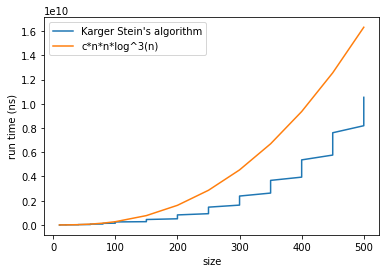

In [ ]:
c_estimates = [round((run_time/ ((n**2)*(math.log2(n)**3))),3) for run_time,n in zip(sorted_runtimes_karger,sorted_sizes_karger)]
c = sum(c_estimates)/len(c_estimates)

reference_karger = [(c*math.pow(n,2)*math.log2(n)**3) for n in (sorted_sizes_karger)]
plt.plot(sizes_karger, sorted_runtimes_karger)
plt.plot(sizes_karger, reference_karger)
plt.legend(["Karger Stein's algorithm", "c*n*n*log^3(n)"])
plt.yscale('linear')
plt.ylabel('run time (ns)')
plt.savefig('karger-stein.png', dpi=300)
plt.xlabel('size')
plt.show()

Karger's total times with respect to the size

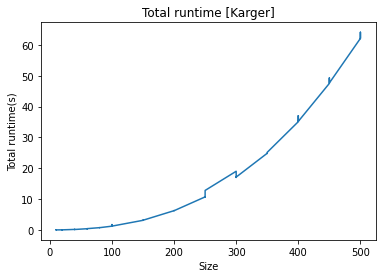

In [ ]:
plt.plot(sizes_karger, total_times_karger)
plt.title('Total runtime [Karger]')
plt.ylabel('Total runtime(s)')
plt.xlabel('Size')
plt.show()

Karger's discovery times with respect to the size

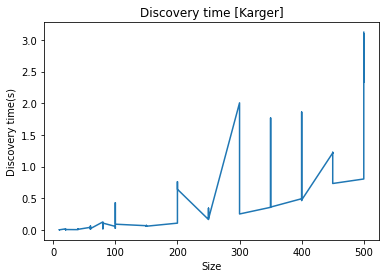

In [ ]:
plt.plot(sizes_karger,discovery_times_karger)
plt.title('Discovery time [Karger]')
plt.ylabel('Discovery time(s)')
plt.xlabel('Size')
plt.show()

Karger's discovery times vs. total times in seconds with respect to the size

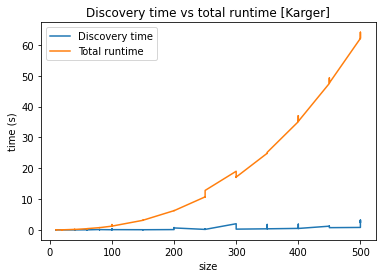

In [ ]:
fig,ax = plt.subplots()
ax.plot(sizes_karger,discovery_times_karger)
plt.plot(sizes_karger, total_times_karger)
plt.legend(["Discovery time", "Total runtime"])
plt.ylabel('time (s)')
plt.title("Discovery time vs total runtime [Karger]")
plt.xlabel('size')
plt.show()

## Stoer and Wagner

In [ ]:
sorted_sizes_stoer = list(zip(*tuples_stoer))[0]
sorted_weights_stoer = list(zip(*tuples_stoer))[1]
sorted_runtimes_stoer = list(zip(*tuples_stoer))[2]

Summary table of Stoer and Wagner's results: sizes of the graph, weights, average times in nanoseconds

In [ ]:
headers = ["Filename","Size","Solution","Time"]
data=[]
for i in range(len(sorted_sizes_stoer)):
  data.append([files[i],tuples_stoer[i][0], tuples_stoer[i][1],tuples_stoer[i][2]])

table = columnar(data,headers, no_borders= False)
print(table)

|-----------------------|-----|--------|---------------|
|Filename               |Size |Solution|Time           |
|======================================================|
|input_random_01_10.txt |10   |3056    |995267.345     |
|-----------------------|-----|--------|---------------|
|input_random_02_10.txt |10   |223     |1829620.705    |
|-----------------------|-----|--------|---------------|
|input_random_03_10.txt |10   |2302    |2754048.74     |
|-----------------------|-----|--------|---------------|
|input_random_04_10.txt |10   |4974    |3549839.765    |
|-----------------------|-----|--------|---------------|
|input_random_05_20.txt |20   |1526    |7025988.8      |
|-----------------------|-----|--------|---------------|
|input_random_06_20.txt |20   |1684    |10409800.51    |
|-----------------------|-----|--------|---------------|
|input_random_07_20.txt |20   |522     |13645381.735   |
|-----------------------|-----|--------|---------------|
|input_random_08_20.txt |20   |

Plot of Stoer-Wagner's complexity (our implementation vs. theoretical)

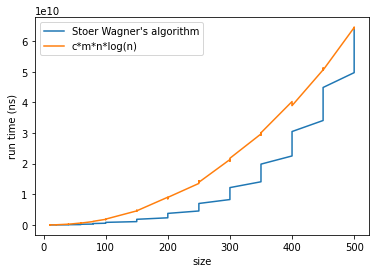

In [ ]:
c_estimates = [round(run_time/(m*n*math.log2(n)),3) for run_time,m,n in zip(sorted_runtimes_stoer,edges,sorted_sizes_stoer)]
c = c_estimates[-1] # we take the last c in c_estimates
reference_stoer = [c*m*n*math.log2(n) for n,m in zip(sorted_sizes_stoer,edges)]
plt.plot(sorted_sizes_stoer, sorted_runtimes_stoer)
plt.plot(sorted_sizes_stoer, reference_stoer)
plt.legend(["Stoer Wagner's algorithm", "c*m*n*log(n)"])
plt.ylabel('run time (ns)')
plt.savefig('stoer_wagner.png', dpi=300)
plt.xlabel('size')
plt.show()

## Comparison
We plot both algorithms' complexities to make a comparison

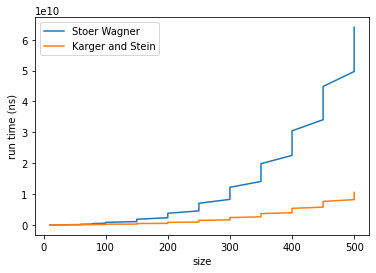

In [ ]:
plt.plot(sorted_sizes_stoer, sorted_runtimes_stoer)
plt.plot(sorted_sizes_stoer, sorted_runtimes_karger)
plt.legend(["Stoer Wagner", "Karger and Stein"])
plt.ylabel('run time (ns)')
plt.savefig('comparison.png', dpi=300)
plt.xlabel('size')
plt.show()

Let's now plot the theoretical complexities together: Stein (O(mnlogn)), Karger (On^2logn^3)

Logarithmic scale:

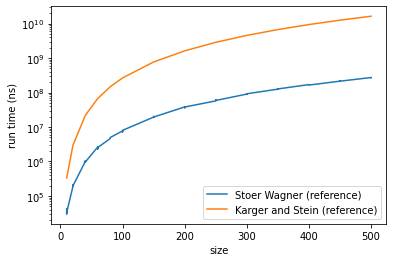

In [ ]:
reference_karger = [(c*math.pow(n,2)*math.log2(n)**3) for n in (sorted_sizes_karger)]
reference_stoer = [c*m*n*math.log2(n) for n,m in zip(sorted_sizes_stoer,edges)]

plt.plot(sorted_sizes_stoer, reference_stoer)
plt.plot(sorted_sizes_stoer, reference_karger)
plt.legend(["Stoer Wagner (reference)", "Karger and Stein (reference)"])
plt.ylabel('run time (ns)')
plt.xlabel('size')
plt.yscale('log')
plt.savefig('comparison_references_logarithm.png', dpi=300)
plt.show()

Linear scale:

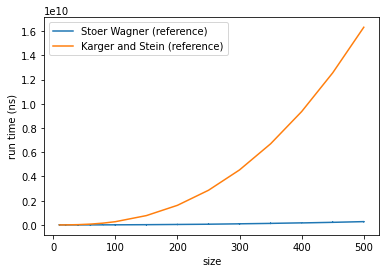

In [ ]:
plt.plot(sorted_sizes_stoer, reference_stoer)
plt.plot(sorted_sizes_stoer, reference_karger)
plt.legend(["Stoer Wagner (reference)", "Karger and Stein (reference)"])
plt.ylabel('run time (ns)')
plt.savefig('comparison_references.png', dpi=300)
plt.xlabel('size')
plt.yscale('linear')
plt.show()